In [1]:
import os
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, load_metric
from tqdm import tqdm

In [2]:
os.chdir('../..')

## Load prediction files

In [3]:
PREDICTION_PATH = 'predictions/albert-xlarge-v2-squadv2-wu=100-lr=3e5-bs=32-msl=384-seed={}/'
SEEDS = [27, 28, 29]
BATCH_SIZE = 32

In [4]:
# Created nested dictionary containing all eval_predictions.json filepaths
prediction_filepath_dict = {}

for seed in SEEDS:
    
    checkpoint_str = list(
        os.walk(PREDICTION_PATH.format(seed))
    )[0][1]
    
    checkpoint_nbr = [int(x.split('-')[-1]) for x in checkpoint_str]
    
    checkpoint_fp = [PREDICTION_PATH.format(seed) + x + '/eval_predictions.json' for x in checkpoint_str]
    
    prediction_filepath_dict[seed] = dict(zip(checkpoint_nbr, checkpoint_fp))

In [5]:
predictions_df = pd.DataFrame()

for seed in tqdm(SEEDS):
    for checkpoint, fp in prediction_filepath_dict[seed].items():
        eval_predictions_df = pd.read_json(fp, orient='index')
        eval_predictions_df.reset_index(inplace=True)
        eval_predictions_df.rename(columns={'index': 'id', 0: "prediction_text"}, inplace=True)
        eval_predictions_df['checkpoint'] = checkpoint
        eval_predictions_df['seed'] = seed

        predictions_df = predictions_df.append(eval_predictions_df)

100%|██████████| 3/3 [01:32<00:00, 30.93s/it]


In [6]:
print(predictions_df.shape)
predictions_df.head()

(2528949, 4)


,id,prediction_text,checkpoint,seed
0,56ddde6b9a695914005b9628,; French: Normand,1,27
1,56ddde6b9a695914005b9629,mixing with the native Frankish and Roman-Gaul...,1,27
2,56ddde6b9a695914005b962a,identity of the Normans emerged initially,1,27
3,56ddde6b9a695914005b962b,identity of the Normans emerged initially,1,27
4,56ddde6b9a695914005b962c,; French: Normand,1,27


In [7]:
11873*3*71

2528949

## Load labels

In [8]:
squad_v2_val = load_dataset('squad_v2', split='validation')

Reusing dataset squad_v2 (/home/sgeorge/.cache/huggingface/datasets/squad_v2/squad_v2/2.0.0/ba48bc29b974701e9ba8d80ac94f3e3df924aba41b764dcf9851debea7c672e4)


In [9]:
squad_v2_val_df = pd.DataFrame(squad_v2_val)
print(squad_v2_val_df.shape)
squad_v2_val_df.head()

(11873, 5)


,answers,context,id,question,title
0,"{'answer_start': [159, 159, 159, 159], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b9628,In what country is Normandy located?,Normans
1,"{'answer_start': [94, 87, 94, 94], 'text': ['1...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b9629,When were the Normans in Normandy?,Normans
2,"{'answer_start': [256, 256, 256, 256], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b962a,From which countries did the Norse originate?,Normans
3,"{'answer_start': [308, 308, 308, 308], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b962b,Who was the Norse leader?,Normans
4,"{'answer_start': [671, 649, 671, 671], 'text':...",The Normans (Norman: Nourmands; French: Norman...,56ddde6b9a695914005b962c,What century did the Normans first gain their ...,Normans


## Merge with categories

In [10]:
squad2_categories = pd.read_csv('data/processed/squad2_dev_simple_categories.csv')
print(squad2_categories.shape)
squad2_categories.head()

(11873, 6)


,id,w8h_label,context_length_bin,question_length_bin,answer_mode_length_bin,unanswerable
0,56ddde6b9a695914005b9628,other,100-200,5-10,1,0
1,56ddde6b9a695914005b9629,when,100-200,5-10,4,0
2,56ddde6b9a695914005b962a,other,100-200,5-10,4,0
3,56ddde6b9a695914005b962b,who,100-200,0-5,1,0
4,56ddde6b9a695914005b962c,what,100-200,5-10,1,0


In [11]:
combined = predictions_df.merge(squad_v2_val_df, on='id', how='inner')

assert combined.shape[0] == predictions_df.shape[0]

combined.head()

,id,prediction_text,checkpoint,seed,answers,context,question,title
0,56ddde6b9a695914005b9628,; French: Normand,1,27,"{'answer_start': [159, 159, 159, 159], 'text':...",The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,Normans
1,56ddde6b9a695914005b9628,; French: Normand,2,27,"{'answer_start': [159, 159, 159, 159], 'text':...",The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,Normans
2,56ddde6b9a695914005b9628,mixing with the native Frankish and Roman-Gaul...,4,27,"{'answer_start': [159, 159, 159, 159], 'text':...",The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,Normans
3,56ddde6b9a695914005b9628,mixing with the native Frankish and Roman-Gaul...,8,27,"{'answer_start': [159, 159, 159, 159], 'text':...",The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,Normans
4,56ddde6b9a695914005b9628,France,128,27,"{'answer_start': [159, 159, 159, 159], 'text':...",The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,Normans


In [12]:
combined = combined.merge(squad2_categories, on='id', how='inner')

assert combined.shape[0] == predictions_df.shape[0]

combined.head()

,id,prediction_text,checkpoint,seed,answers,context,question,title,w8h_label,context_length_bin,question_length_bin,answer_mode_length_bin,unanswerable
0,56ddde6b9a695914005b9628,; French: Normand,1,27,"{'answer_start': [159, 159, 159, 159], 'text':...",The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,Normans,other,100-200,5-10,1,0
1,56ddde6b9a695914005b9628,; French: Normand,2,27,"{'answer_start': [159, 159, 159, 159], 'text':...",The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,Normans,other,100-200,5-10,1,0
2,56ddde6b9a695914005b9628,mixing with the native Frankish and Roman-Gaul...,4,27,"{'answer_start': [159, 159, 159, 159], 'text':...",The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,Normans,other,100-200,5-10,1,0
3,56ddde6b9a695914005b9628,mixing with the native Frankish and Roman-Gaul...,8,27,"{'answer_start': [159, 159, 159, 159], 'text':...",The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,Normans,other,100-200,5-10,1,0
4,56ddde6b9a695914005b9628,France,128,27,"{'answer_start': [159, 159, 159, 159], 'text':...",The Normans (Norman: Nourmands; French: Norman...,In what country is Normandy located?,Normans,other,100-200,5-10,1,0


Get number of examples seen for each checkpoint

In [13]:
combined['num_examples'] = combined['checkpoint'] * BATCH_SIZE

## Evaluation function

In [14]:
SQUAD_V2_METRIC = load_metric("squad_v2")

In [15]:
SQUAD_V2_METRIC

Metric(name: "squad_v2", features: {'predictions': {'id': Value(dtype='string', id=None), 'prediction_text': Value(dtype='string', id=None), 'no_answer_probability': Value(dtype='float32', id=None)}, 'references': {'id': Value(dtype='string', id=None), 'answers': Sequence(feature={'text': Value(dtype='string', id=None), 'answer_start': Value(dtype='int32', id=None)}, length=-1, id=None)}}, usage: """
Computes SQuAD v2 scores (F1 and EM).
Args:
    predictions: List of triple for question-answers to score with the following elements:
        - the question-answer 'id' field as given in the references (see below)
        - the text of the answer
        - the probability that the question has no answer
    references: List of question-answers dictionaries with the following key-values:
            - 'id': id of the question-answer pair (see above),
            - 'answers': a list of Dict {'text': text of the answer as a string}
    no_answer_threshold: float
        Probability threshold

In [16]:
def squad2_evaluation(id_list, prediction_text_list, answers_list):
    predictions = [
        {
            'prediction_text': prediction_text, 
            'id': _id, 
            'no_answer_probability': 0.0  # Same as https://github.com/huggingface/transformers/blob/master/examples/pytorch/question-answering/run_qa.py#L532
        } for 
        _id, prediction_text in zip(id_list, prediction_text_list)
    ]
    
    references = [
        {
            'id': _id, 
            'answers': answers
        } for 
        _id, answers in zip(id_list, answers_list)
    ]
    
    metrics = SQUAD_V2_METRIC.compute(predictions=predictions, references=references)
    
    return metrics

Check:

In [17]:
np.random.seed(3)
combined.sample(n=1)

MemoryError: Unable to allocate 193. MiB for an array with shape (10, 2528949) and data type object

In [ ]:
squad2_evaluation(
    id_list=list(combined[(combined['checkpoint'] == 6016) & (combined['seed'] == 29)]['id']), 
    prediction_text_list=list(combined[(combined['checkpoint'] == 6016) & (combined['seed'] == 29)]['prediction_text']), 
    answers_list=list(combined[(combined['checkpoint'] == 6016) & (combined['seed'] == 29)]['answers'])
)

In [ ]:
np.random.seed(33)
combined.sample(n=1)

In [ ]:
squad2_evaluation(
    id_list=list(combined[(combined['checkpoint'] == 4864) & (combined['seed'] == 28)]['id']), 
    prediction_text_list=list(combined[(combined['checkpoint'] == 4864) & (combined['seed'] == 28)]['prediction_text']), 
    answers_list=list(combined[(combined['checkpoint'] == 4864) & (combined['seed'] == 28)]['answers'])
)

Both match values in `eval_results.json`

In [ ]:
overall_f1_perf = []

for seed in SEEDS:
    for checkpoint in tqdm(combined['checkpoint'].unique()):
        
        subset = combined.copy()[(combined['checkpoint'] == checkpoint) & (combined['seed'] == seed)]
        
        eval_output = squad2_evaluation(
            id_list=list(subset['id']), 
            prediction_text_list=list(subset['prediction_text']), 
            answers_list=list(subset['answers'])
        )

        overall_f1_perf.append(
            {
                'seed': seed,
                'overall_f1': eval_output['f1'],
                'checkpoint': checkpoint,
                'overall_exact': eval_output['exact']
            }
        )

In [ ]:
overall_f1_perf_df = pd.DataFrame(overall_f1_perf)
print(overall_f1_perf_df.shape)
overall_f1_perf_df.head()

In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(data=overall_f1_perf_df, x='checkpoint', y='overall_f1')
plt.show()

In [ ]:
combined.shape

In [ ]:
combined = combined.merge(overall_f1_perf_df, on=['checkpoint', 'seed'])
combined.shape

## Plots

### WWWWWWH questions

In [ ]:
combined.head()

In [ ]:
combined['w8h_label'].unique()

In [ ]:
combined['w8h_label'].nunique()

In [ ]:
8*3*71

In [ ]:
full_metrics = []

for seed, num_examples, label in tqdm(
    list(
        itertools.product(
            SEEDS, 
            combined['num_examples'].unique(), 
            combined['w8h_label'].unique()
        )
    )
):

    combined_subset = combined.copy()[
        (combined['w8h_label'] == label) & 
        (combined['num_examples'] == num_examples) &
        (combined['seed'] == seed)
    ]

    id_list = list(combined_subset['id'])
    prediction_text_list = list(combined_subset['prediction_text'])
    answers_list = list(combined_subset['answers'])

    metrics = squad2_evaluation(
        id_list=id_list, 
        prediction_text_list=prediction_text_list, 
        answers_list=answers_list
    )

    metrics['w8h_label'] = label
    metrics['num_examples'] = num_examples
    metrics['seed'] = seed

    full_metrics.append(metrics)

In [ ]:
full_metrics_df = pd.DataFrame(full_metrics)
print(full_metrics_df.shape)
full_metrics_df.head()

In [ ]:
full_metrics_df['checkpoint'] = full_metrics_df['num_examples'] / BATCH_SIZE

In [ ]:
full_metrics_df = full_metrics_df.merge(overall_f1_perf_df, on=['seed', 'checkpoint'])
full_metrics_df.shape

In [ ]:
full_metrics_df.to_csv('data/processed/metrics_by_w6h-albert-xlarge-v2-squadv2-wu=100-lr=3e5-bs=32-msl=384.csv', index=False)

__WWWWWWH F1 by number of examples__

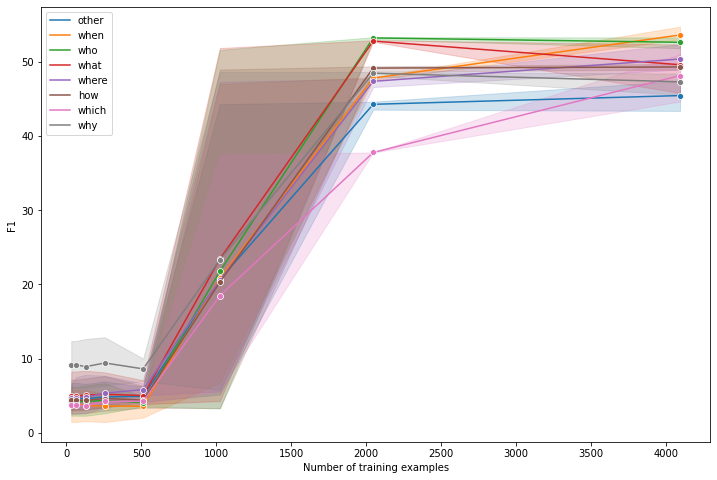

In [40]:
plt.figure(figsize=(12, 8))
plt.xlabel('Number of training examples')
plt.ylabel('F1')
sns.lineplot(data=full_metrics_df, y='f1', x='num_examples', hue='w8h_label', marker='o', palette='tab10')
plt.legend()
plt.show()

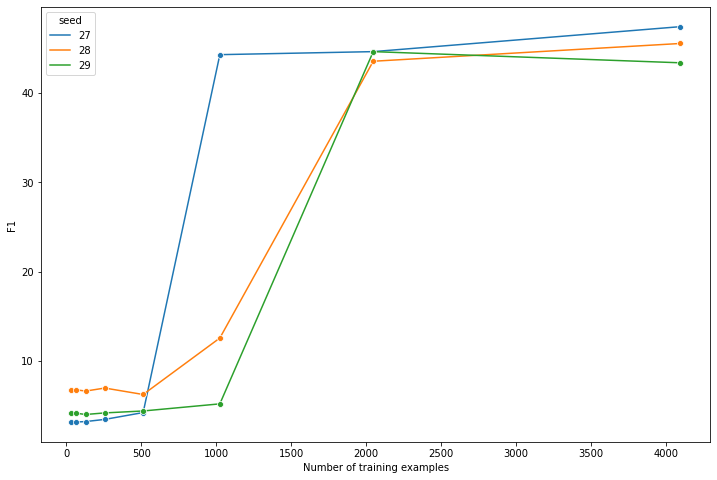

In [42]:
plt.figure(figsize=(12, 8))
plt.xlabel('Number of training examples')
plt.ylabel('F1')
sns.lineplot(data=full_metrics_df[full_metrics_df['w8h_label'] == 'other'], y='f1', x='num_examples', hue='seed', marker='o', palette='tab10')
plt.legend(title='seed')
plt.show()

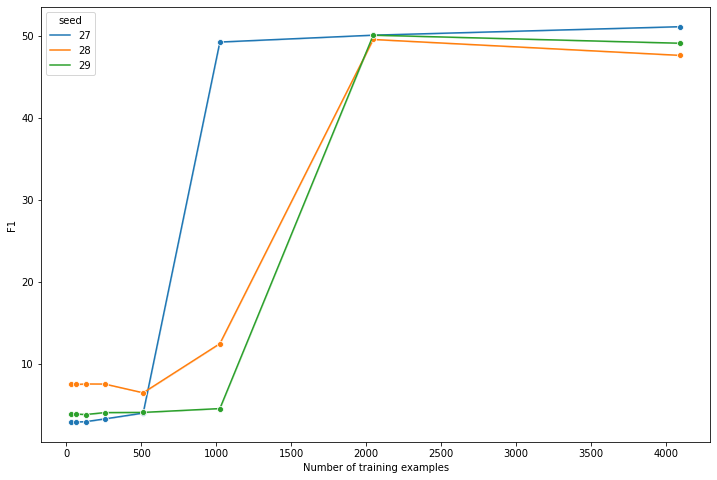

In [44]:
plt.figure(figsize=(12, 8))
plt.xlabel('Number of training examples')
plt.ylabel('F1')
sns.lineplot(data=full_metrics_df, y='overall_f1', x='num_examples', hue='seed', marker='o', palette='tab10')
plt.legend(title='seed')
plt.show()